# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [20]:
# Load pickled data
import pickle
import csv

#Load data-set
training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'
#Load sign classes
sign_names_file = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(sign_names_file, mode='r') as f:
	reader = csv.reader(f)
	sign_names = {rows[0]:rows[1] for rows in reader}  
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
n_train = X_train.shape[0]
n_validation = X_validation.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = len(sign_names)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Plotting some image examples of the data-set.

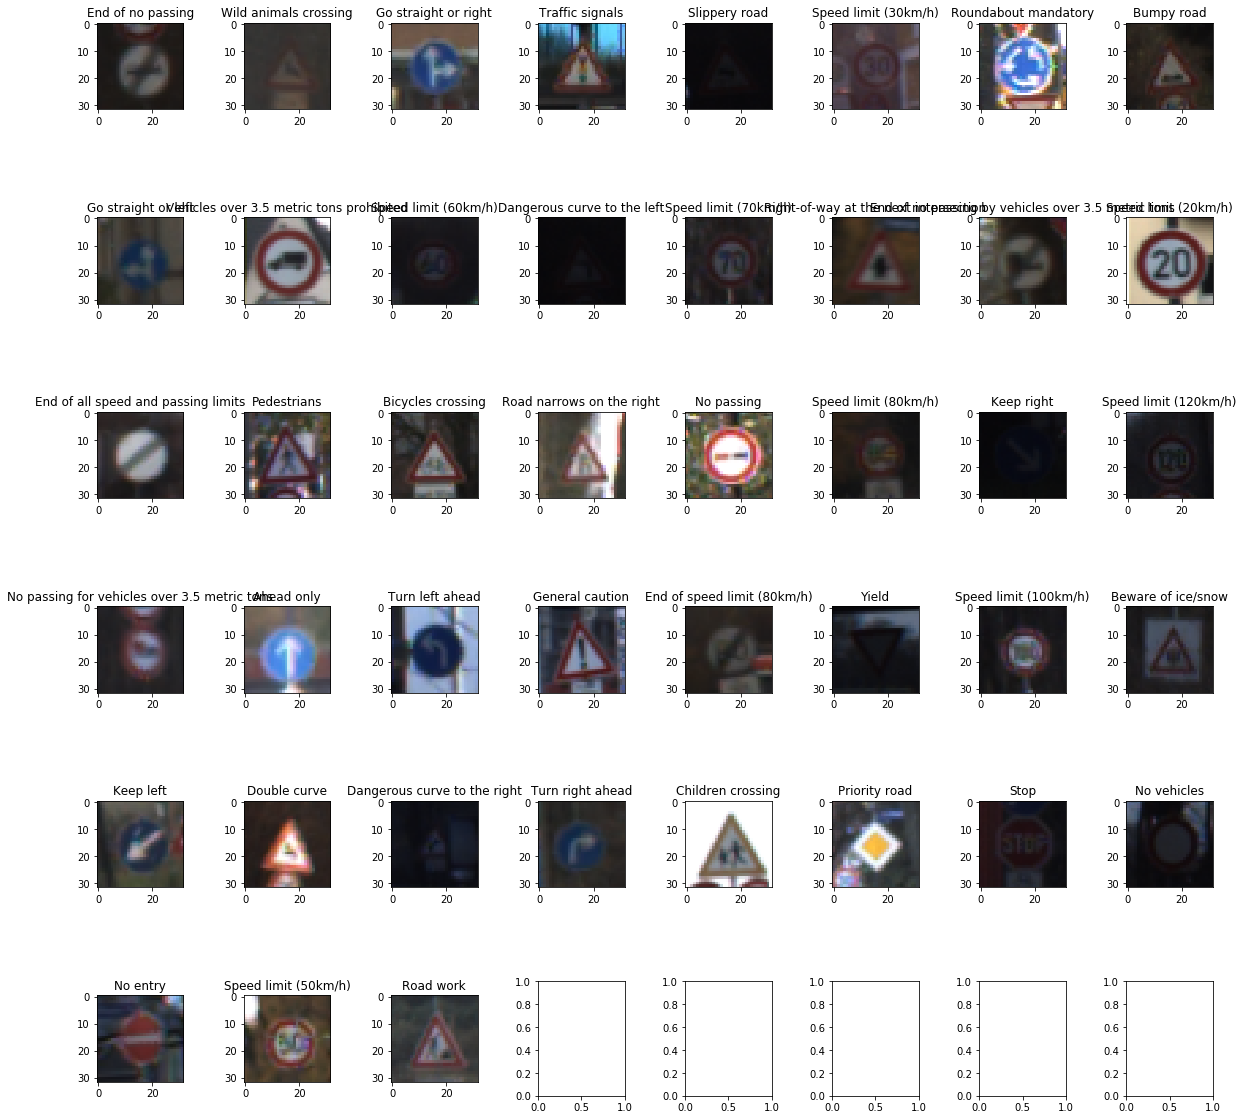

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 8, figsize=(20, 20))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
sign_classes = sign_names.values()
last_label = -1
r = 0
c = 0
for feature, label in zip(list(X_train), list(y_train)):
    try:
        sign = sign_names.pop(str(label))
        if(c > 7): 
            c = 0
            r += 1
        axes[r,c].set_title(sign)
        axes[r,c].imshow(feature)
        c += 1
    except KeyError:
        pass
plt.show()
%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
# Here the only preprocessing that it is applied is normalization between [-1,1]
from sklearn.utils import shuffle
import time
import cv2
import numpy as np

X_train, y_train = shuffle(X_train, y_train)
def normalizeImages(X_images):
    images =[]
    for img in X_images:
        img = (img-127.0)/255.0
        images.append(img)
    """print("append ", time.clock()-start_time,
          "SHAPE: ", X_images.shape, "SIZE: ", len(X_images),
          "SIZE: ", len(images_to_save))"""
    return np.array(images)

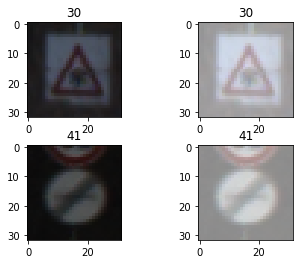

In [5]:
#Applying preprocessing to training and validation data. Also, there's 2 random images of every data set to see
#how the data seems ike after the preprocession
X_train_norm = normalizeImages(X_train)

X_validation_norm = normalizeImages(X_validation)


fig, axes = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3, wspace=0.05)

axes[0,0].imshow(X_train[10])
axes[0,0].set_title(y_train[10])

axes[0,1].imshow(X_train_norm[10])
axes[0,1].set_title(y_train[10])

axes[1,0].imshow(X_validation[10])
axes[1,0].set_title(y_validation[10])

axes[1,1].imshow(X_validation_norm[10])
axes[1,1].set_title(y_validation[10])
plt.show()

## Normalize test

In [6]:
X_test_norm = normalizeImages(X_test)

### Model Architecture

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

strides = 1
n_classes = 43

learning_rate = 0.0015
EPOCHS = 30
BATCH_SIZE = 64
dropout = 0.5
layer_1_depth = 20
layer_2_depth = 65
layer_11_depth = 130
layer_3_depth = 160
layer_4_depth = 110
layer_5_depth = 55
layers = []

weights = {
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 3, layer_1_depth],stddev=0.1)),
    'wc2': tf.Variable(tf.truncated_normal([5, 5, layer_1_depth, layer_2_depth],stddev=0.1)),
    'wc11': tf.Variable(tf.truncated_normal([1, 1, layer_2_depth, layer_11_depth],stddev=0.1)),
    'wd1': tf.Variable(tf.truncated_normal([5*5*layer_11_depth, layer_3_depth],stddev=0.1)),
    'wd2': tf.Variable(tf.truncated_normal([layer_3_depth, layer_4_depth],stddev=0.1)),
    'wd3': tf.Variable(tf.truncated_normal([layer_3_depth, layer_5_depth],stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([layer_5_depth, n_classes],stddev=0.1))}

biases = {
    'bc1': tf.Variable(tf.zeros([layer_1_depth])),
    'bc2': tf.Variable(tf.zeros([layer_2_depth])),
    'bc11': tf.Variable(tf.zeros([layer_11_depth])),
    'bd1': tf.Variable(tf.zeros([layer_3_depth])),
    'bd2': tf.Variable(tf.zeros([layer_4_depth])),
    'bd3': tf.Variable(tf.zeros([layer_5_depth])),
    'out': tf.Variable(tf.zeros([n_classes]))}
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3.
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, strides, strides, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])
    conv1 = tf.nn.relu(conv1)
    #Pooling. Input = 28x28x20. Output = 14x14x20.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layers.append(conv1)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(conv1, weights['wc2'], strides=[1,strides, strides, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 3: 1x1 LAYER
    conv11 = tf.nn.conv2d(conv2, weights['wc11'], strides=[1,strides, strides, 1], padding='VALID')
    conv11 = tf.nn.bias_add(conv11, biases['bc11'])
    conv11 = tf.nn.relu(conv11)
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(conv11)
     
    # Layer 4: Fully Connected
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    # Layer 5: Fully Connected
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    
    # Layer 6: Fully Connected
    fc3 = tf.add(tf.matmul(fc1, weights['wd3']), biases['bd3'])
    fc3 = tf.nn.relu(fc3)

    # Layer 7: Fully Connected
    logits = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels= one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples), (total_loss / num_examples)

<class 'tensorflow.python.framework.ops.Tensor'>


Training...

EPOCH 1 ...
Validation Accuracy = 0.902
Validation loss = 0.337



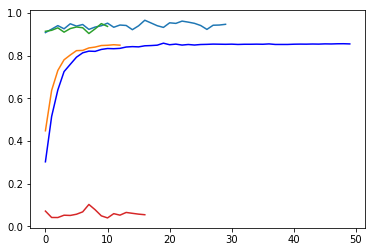

EPOCH 2 ...
Validation Accuracy = 0.921
Validation loss = 0.255



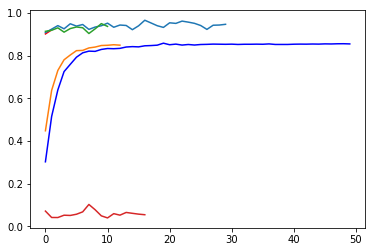

EPOCH 3 ...
Validation Accuracy = 0.937
Validation loss = 0.234



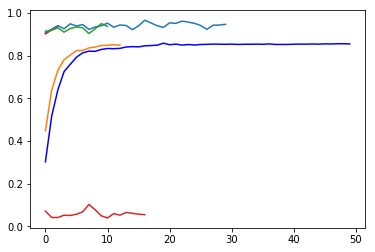

EPOCH 4 ...
Validation Accuracy = 0.937
Validation loss = 0.275



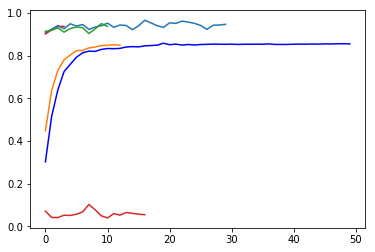

EPOCH 5 ...
Validation Accuracy = 0.940
Validation loss = 0.244



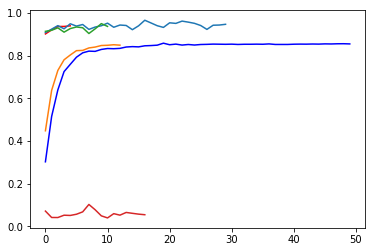

EPOCH 6 ...
Validation Accuracy = 0.925
Validation loss = 0.288



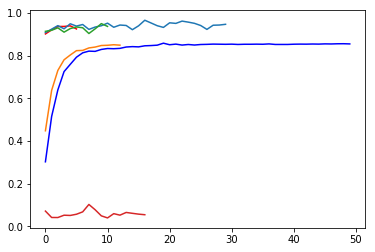

EPOCH 7 ...
Validation Accuracy = 0.948
Validation loss = 0.225



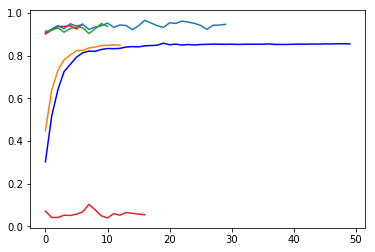

EPOCH 8 ...
Validation Accuracy = 0.935
Validation loss = 0.352



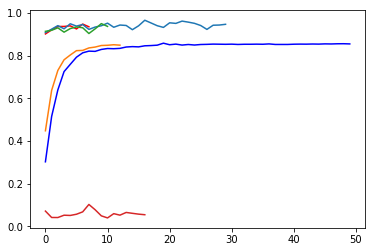

EPOCH 9 ...
Validation Accuracy = 0.946
Validation loss = 0.248



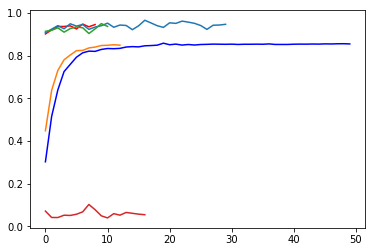

EPOCH 10 ...
Validation Accuracy = 0.943
Validation loss = 0.291



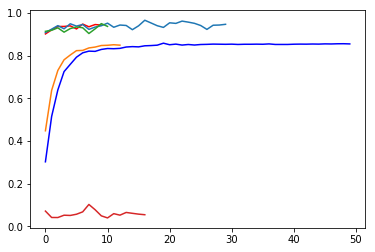

EPOCH 11 ...
Validation Accuracy = 0.929
Validation loss = 0.434



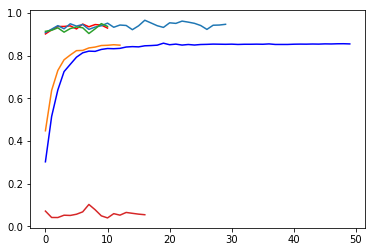

EPOCH 12 ...
Validation Accuracy = 0.935
Validation loss = 0.361



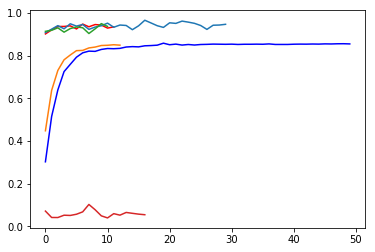

EPOCH 13 ...
Validation Accuracy = 0.950
Validation loss = 0.303



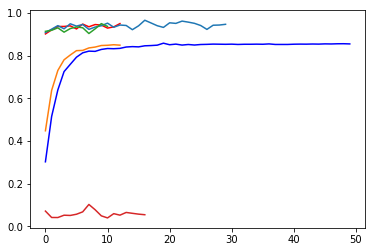

EPOCH 14 ...
Validation Accuracy = 0.921
Validation loss = 0.504



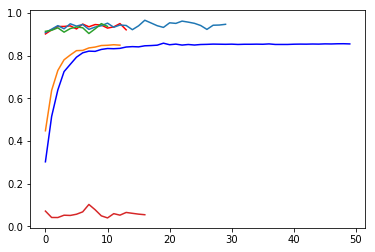

EPOCH 15 ...
Validation Accuracy = 0.955
Validation loss = 0.294



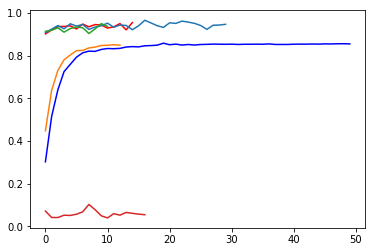

EPOCH 16 ...
Validation Accuracy = 0.915
Validation loss = 0.483



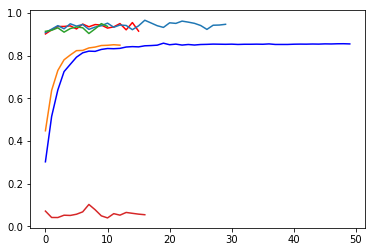

EPOCH 17 ...
Validation Accuracy = 0.943
Validation loss = 0.344



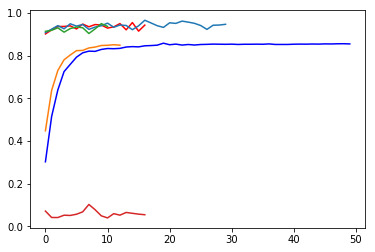

EPOCH 18 ...
Validation Accuracy = 0.951
Validation loss = 0.324



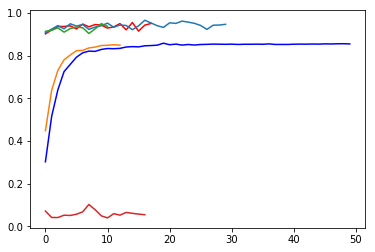

EPOCH 19 ...
Validation Accuracy = 0.946
Validation loss = 0.395



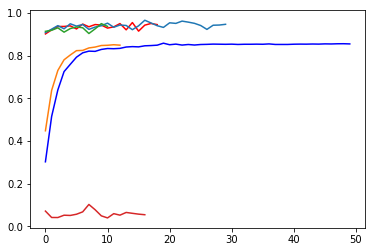

EPOCH 20 ...
Validation Accuracy = 0.926
Validation loss = 0.452



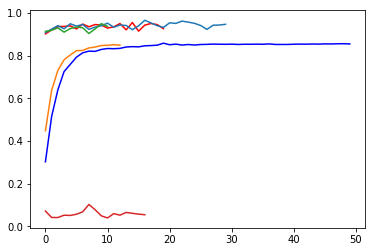

EPOCH 21 ...
Validation Accuracy = 0.950
Validation loss = 0.325



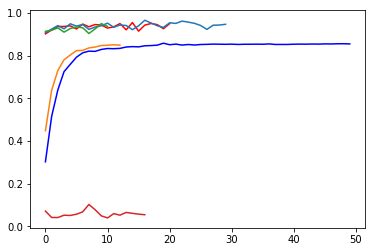

EPOCH 22 ...
Validation Accuracy = 0.951
Validation loss = 0.382



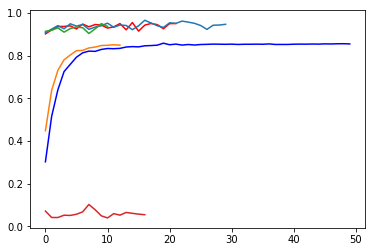

EPOCH 23 ...
Validation Accuracy = 0.941
Validation loss = 0.533



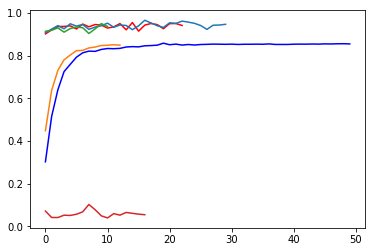

EPOCH 24 ...
Validation Accuracy = 0.935
Validation loss = 0.415



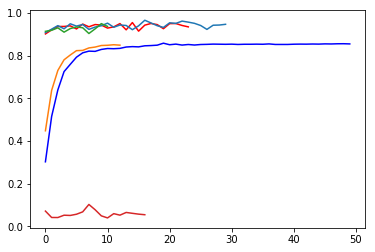

EPOCH 25 ...
Validation Accuracy = 0.959
Validation loss = 0.348



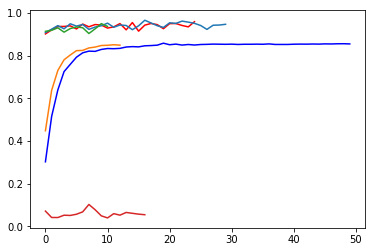

EPOCH 26 ...
Validation Accuracy = 0.940
Validation loss = 0.469



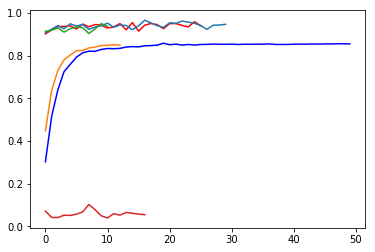

EPOCH 27 ...
Validation Accuracy = 0.949
Validation loss = 0.419



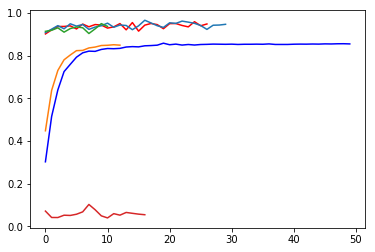

EPOCH 28 ...
Validation Accuracy = 0.958
Validation loss = 0.343



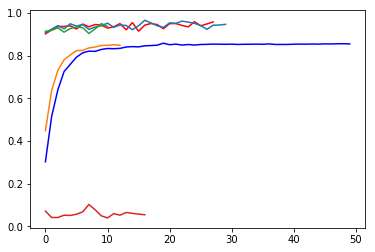

EPOCH 29 ...
Validation Accuracy = 0.951
Validation loss = 0.419



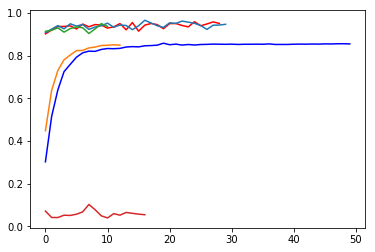

EPOCH 30 ...
Validation Accuracy = 0.968
Validation loss = 0.269



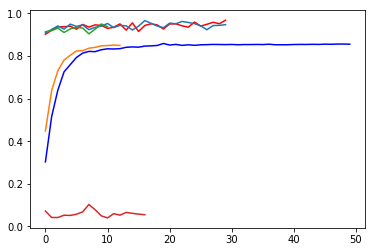

Model saved


In [13]:
values = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_norm)
    print("Training...")
    print()
    old_values = pickle.load(open('values.txt','rb'))
    old_values2 = pickle.load(open('values0.00200.txt','rb'))
    old_values3 = pickle.load(open('values0.00110.txt','rb'))
    old_values4 = pickle.load(open('values0.00300.txt','rb'))
    old_values5 = pickle.load(open('values0.00040.txt','rb'))
    
    for i in range(EPOCHS):
        X_train_norm, y_train = shuffle(X_train_norm, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_norm[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        accuracy, loss = evaluate(X_validation_norm, y_validation)
        values.append([i+1,accuracy])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}\nValidation loss = {:.3f}".format(accuracy, loss))
        print()
        plt.plot([t[1] for t in values],'r')
        plt.plot([t[1] for t in old_values],'b')
        plt.plot([t[1] for t in old_values2])
        plt.plot([t[1] for t in old_values3])
        plt.plot([t[1] for t in old_values4])
        plt.plot([t[1] for t in old_values5])
        #plt.plot(range(EPOCHS),,'r')
        plt.show()
        pickle.dump(values, open('values'+'{:.5f}'.format(learning_rate)+'.txt', 'wb'))
        
    saver.save(sess, './lenet')
    print("Model saved")

In [14]:
### Test
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]))

Test Accuracy = 0.946


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

0


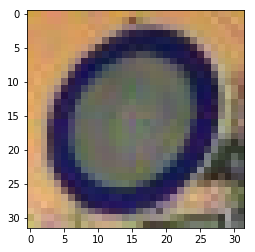

1


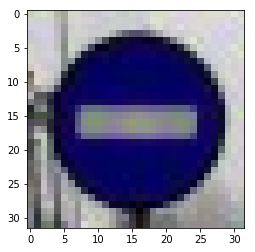

2


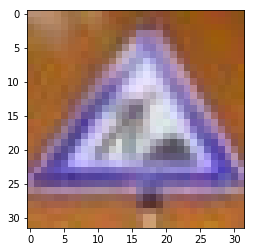

3


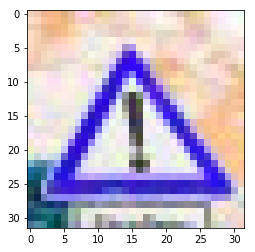

4


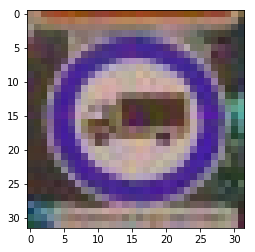

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import cv2

folder = './test_images'
test_images = []
for file in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,file))
    test_images.append(img)    
for val in range(len(test_images)):
    print(val)
    plt.imshow(test_images[val])
    plt.show()
    
test_images = normalizeImages(test_images)
    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

y_prediction = tf.nn.softmax(logits)
top5_prediction = tf.nn.top_k(y_prediction, 5)
y_predicted_class = tf.argmax(logits, 1)
with tf.Session() as sess:
    
    saver.restore(sess, './lenet')
    
    pred_class = sess.run(y_predicted_class, feed_dict={x: test_images})
    top5_prob = sess.run(top5_prediction, feed_dict={x: test_images})
    
    for i in range(0,5):
        print("\nImage {}: {} which is '{}' class predicted with a {:.3f} probability".format(i,top5_prob[1][i][0], sign_names.get(str(top5_prob[1][i][0])), top5_prob[0][i][0]))
        print("Top 5 predictions:")
        for j in range(0,4):
            print("\t{} class \twith a value of {:.3f} which is '{}' class".format(top5_prob[1][i][j], top5_prob[0][i][j], sign_names.get(str(top5_prob[1][i][j]))))
              
    


Image 0: 13 which is 'Yield' class predicted with a 0.856 probability
Top 5 predictions:
	13 class 	with a value of 0.856 which is 'Yield' class
	15 class 	with a value of 0.135 which is 'No vehicles' class
	40 class 	with a value of 0.005 which is 'Roundabout mandatory' class
	38 class 	with a value of 0.002 which is 'Keep right' class

Image 1: 17 which is 'No entry' class predicted with a 1.000 probability
Top 5 predictions:
	17 class 	with a value of 1.000 which is 'No entry' class
	8 class 	with a value of 0.000 which is 'Speed limit (120km/h)' class
	26 class 	with a value of 0.000 which is 'Traffic signals' class
	14 class 	with a value of 0.000 which is 'Stop' class

Image 2: 18 which is 'General caution' class predicted with a 0.840 probability
Top 5 predictions:
	18 class 	with a value of 0.840 which is 'General caution' class
	37 class 	with a value of 0.160 which is 'Go straight or left' class
	20 class 	with a value of 0.001 which is 'Dangerous curve to the right' class
	

### Analyze Performance

4 of 5 images have been correctly detected. Because image number 2 is predicted to be 'General caution' but you can clearly see that is a road work.

There is an interesting observation where we can see that image 2 does not have in the top 5 predictions the correct class of the signal.

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 